/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/arthur/software/a

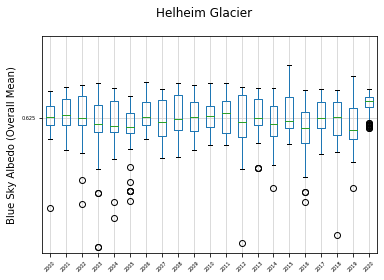

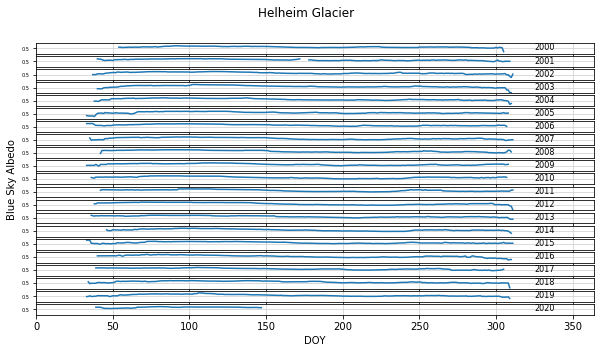

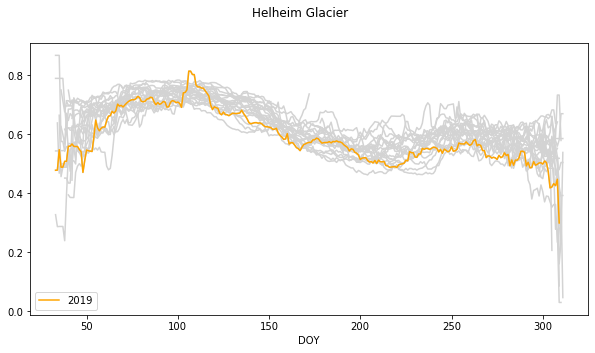

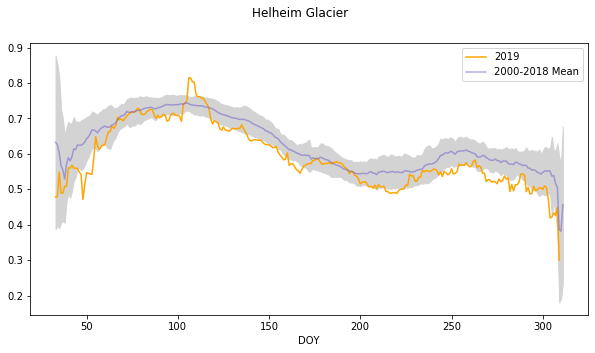

In [67]:
# This makes a plot where all years are stacked up on top of each other, with a color ramp to generally
# tell them apart
import pandas as pd
import datetime as dt
import numpy as np
import os

import matplotlib.cm as cm
from pandas import DataFrame
from pandas import Grouper
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Update these as needed
workspace='/home/arthur/Dropbox/projects/greenland/aoi_albedo_time_series/'
csv_name = 'helheim-coastal-subset-MCD43A3-006-results.csv'
aoi_name = 'Helheim Glacier'
dt_indx = pd.date_range('2000-01-01', '2020-12-31')

csv_path = workspace + csv_name

# Define the fields of interest so we can ignore the rest
fields = ['Date','MCD43A3_006_Albedo_WSA_shortwave', 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']

# Import raw APPEARS output
ts_df = pd.read_csv(csv_path, usecols=fields, parse_dates=[0], index_col=0)

# Add missing dates to beginning of modis time series
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2000, 2, 23)
daterange = pd.date_range(start_date, end_date)
del start_date, end_date
empty_wsa = np.full([54,], 32767, dtype=float)
empty_qa = np.full([54,], 255, dtype=int)

pad_df = pd.DataFrame({'Date': daterange, 'MCD43A3_006_Albedo_WSA_shortwave': empty_wsa,
                       'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave': empty_qa})
pad_df.set_index('Date', inplace=True)

# Add to beginning of data series
ts_df = pd.concat([pad_df, ts_df])

# Mask out fill values (and could optionally also mask out mag inversions by adding another condition == 1
ts_df['MCD43A3_006_Albedo_WSA_shortwave'].mask(ts_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'] == 255,
                                               np.NaN, inplace=True)
ts_df['SW_WSA'] = ts_df['MCD43A3_006_Albedo_WSA_shortwave']
del ts_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
del ts_df['MCD43A3_006_Albedo_WSA_shortwave']
ts_df = ts_df.groupby(['Date']).mean()

# # Plot 2019 (and 2020?) separately, on top of all other years, since it is of interest
# ts_df_2017 = ts_df.loc['2017-01-01':'2017-12-31'].copy()
# ts_df_2019 = ts_df.loc['2019-01-01':'2019-12-31'].copy()
# ts_df_2020 = ts_df.loc['2020-01-01':'2020-12-31'].copy()
#
# # These set the indices for the output in such a way that they can be plotted on top of each other year-wise
# # I may just delete these if I find a good enough colormap
# idx = pd.MultiIndex.from_arrays([
#         pd.to_datetime(ts_df.index.strftime('2012-%m-%d')),
#         ts_df.index.year
#     ])
#
# #TODO maybe: could make this a list of indices instead of hard coded
# idx_2017 = pd.MultiIndex.from_arrays([
#         pd.to_datetime(ts_df_2017.index.strftime('2012-%m-%d')),
#         ts_df_2017.index.year
#     ])
#
# idx_2019 = pd.MultiIndex.from_arrays([
#         pd.to_datetime(ts_df_2019.index.strftime('2012-%m-%d')),
#         ts_df_2019.index.year
#     ])
#
# idx_2020 = pd.MultiIndex.from_arrays([
#         pd.to_datetime(ts_df_2020.index.strftime('2012-%m-%d')),
#         ts_df_2020.index.year
#     ])
#
# #colors = cm.Purples(np.linspace(0,1,21))
# colors = cm.gnuplot2_r(np.linspace(0,1,21))
#
# # This whole thing is hacky -- would be better to replace with native matplotlibs, maybe
# # using a list of dfs, one per year
# ax = ts_df.set_index(idx).unstack().SW_WSA.plot(color=colors, figsize=(40,18), fontsize=16)
# #ax_2017 = ts_df_2017.set_index(idx_2017).unstack().SW_WSA.plot(ax=ax, color='Black')
# ax_2019 = ts_df_2019.set_index(idx_2019).unstack().SW_WSA.plot(ax=ax, color='Green')
# #ax_2020 = ts_df_2020.set_index(idx_2020).unstack().SW_WSA.plot(ax=ax, color='Red')
# lg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1, fontsize=24)
#
# # format the ticks as months
# months = mdates.MonthLocator()  # every month
# ax.xaxis.set_major_locator(months)
#
# ax.set_xlabel('Date', fontsize=30)
# ax.set_ylabel('Blue Sky Albedo', fontsize=30)
# plt.suptitle(aoi_name, fontsize=30)
# plt.savefig(fname=str(csv_path[:-4]  + 'blue_sky_time_series_stacked.png'), dpi=300, bbox_inches='tight')
#


#### Now make a plot where each year is displayed separately
series = ts_df.squeeze()

strt_year = dt_indx[0].to_pydatetime().year
end_year = dt_indx[-1].to_pydatetime().year
nyears = end_year - strt_year

series = series.reindex(dt_indx, fill_value=np.NaN)

groups = series.groupby(Grouper(freq='A'))
years = DataFrame()

for name, group in groups:
    years[name.year] = group.values[:364]

#TODO figure out why the original years df doesn't work correctly below. Temp solution reread from csv..
years.to_csv(csv_path[:-4] + 'temp.csv')
years_df = pd.read_csv(csv_path[:-4] + 'temp.csv')
os.remove(csv_path[:-4] + 'temp.csv')


# Quck boxplot for each year
years.boxplot()
overall_mean = years.stack().mean()
#print(overall_mean)
data_to_plot = []

year_tics = [*range(strt_year, end_year + 1, 1)]
for year_col in year_tics:
    if '20' in str(year_col):
        data_to_plot.append(years[year_col].to_numpy())

# Create a figure instance
fig_box = plt.figure(1, figsize=(9, 6))
fig_box.suptitle(aoi_name)

# Create an axis instance
ax_box = fig_box.add_subplot(111)
ax_box.set_xticks([])
ax_box.tick_params(
    axis='x',
    labelsize=5,
    labelrotation=45
                   )
ax_box.set_ylim(0.0, 1.0)
ax_box.grid(b=True, which='major', color='LightGrey', linestyle='-')
ax_box.set_yticks([0.6246606091915821])
ax_box.tick_params(
    axis='y',
    labelsize=5
               )
ax_box.set_ylabel('Blue Sky Albedo (Overall Mean)')

# Create the boxplot
ax_box.boxplot(data_to_plot)
fig_box.savefig(csv_path[:-4] + '_boxplot.png', dpi=300)

# Old crappier plot directly from pandas df.plot()
#years.plot(subplots=True, figsize=(20,17), ylim=(0.0, 1.0), yticks=[0.5], legend=False, ax=ax2) #, grid=True)

ncols = 1
nrows = nyears + 1

# create the plots
fig = plt.figure(figsize=(10,5))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1 ) for r in range(0, nrows) for c in range(0, ncols) ]

#colors = cm.gnuplot2_r(np.linspace(0,1,21))

yr = strt_year
# add the data one year at a time
for ax in axes:
    col = str(yr)
    ax.plot(years_df[col])
    ax.set_xlim(0,364)
    ax.set_ylim(0.0, 1.0)
    ax.grid(b=True, which='major', color='LightGrey', linestyle='-')
    ax.set_yticks([0.5])
    ax.tick_params(
        axis='y',
        labelsize=5
                   )
    ax.text(325, 0.33, str(yr), fontsize=8)
    # Remove ticks for everything but final year so no overlapping/messiness
    if yr != end_year:
        ax.set_xticklabels([])
    # Add label to middle year
    if yr == round((end_year + strt_year) / 2, 0):
        ax.set_ylabel('Blue Sky Albedo')
    yr += 1

# This only needs to apply to the last ax
ax.set_xlabel('DOY')
fig.suptitle(aoi_name)

# plt.xticks(np.linspace(15,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr',
#                                         'May', 'Jun', 'Jul', 'Aug',
#                                         'Sep', 'Oct', 'Nov', 'Dec'))

#plt.tight_layout()
plt.savefig(csv_path[:-4] + 'blue_sky_time_series.png', dpi=300, bbox_inches='tight')

#### Try doing the all stacked up plot but using the strategy from the subplots approach

fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

#TODO this doesn't work yet, from:
# https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=20) #vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Add each year to same plot -- for some reason a 'undefined' values comes back first, so
# check for year part first
for ycol in years_df.columns:
    if '20' in ycol:
        ax2.plot(years_df.index, years_df[ycol], color="lightgrey")

ax2.plot(years_df.index, years_df['2019'], label='2019', color="orange")
ax2.set_xlabel('DOY')
fig2.suptitle(aoi_name)
plt.legend(ncol=3, loc='lower left')
plt.savefig(csv_path[:-4] + 'blue_sky_time_series_2.png', dpi=300, bbox_inches='tight')

# #### Now plot 2019 vs the 2000 - 2018 avg
# Calculate stats
cols = years_df.loc[:, "2000":"2018"]
years_df['base_mean'] = cols.mean(axis=1)
years_df['base_sd'] = cols.std(axis=1)

fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.plot(years_df.index, years_df['2019'], label='2019', color='orange')
ax3.plot(years_df.index, years_df['base_mean'], label='2000-2018 Mean', color='slateblue', alpha=0.5)
plt.fill_between(years_df.index, years_df['base_mean']-years_df['base_sd'], years_df['base_mean']+years_df['base_sd'],
                 color='lightgrey')

ax3.set_xlabel('DOY')
plt.legend()

fig3.suptitle(aoi_name)

plt.savefig(csv_path[:-4] + 'blue_sky_time_series_3.png', dpi=300, bbox_inches='tight')
